# Info

https://www.kaggle.com/datasets/balabaskar/tom-and-jerry-image-classification

# Libraries Import

In [1]:
import glob
import cv2
import tqdm

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import kagglehub

In [4]:
import os
from collections import Counter
import random
import re
import json
import pickle

In [5]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization, Concatenate
from tensorflow.keras.layers import AvgPool2D, UpSampling2D, concatenate, Conv2DTranspose, GlobalAvgPool2D, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import plot_model
import tensorflow as tf

from tensorflow.keras.applications import ResNet50

2025-07-20 21:51:47.732009: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753048308.088536      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753048308.191493      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [7]:
from concurrent.futures import ThreadPoolExecutor

# Constants

In [8]:
IMG_W = 224
IMG_H = 224

BATCH_SIZE = 32

VAL_SPLIT = 0.2

BASE_DIR = r'/kaggle/working/'
# BASE_DIR = ''

# Functions

In [9]:
def save_obj(obj, file_name):
    with open(file_name, 'wb') as f:
        pickle.dump(obj, f)

def load_obj(file_name):
    with open(file_name, 'rb') as f:
        return pickle.load(f)

# Dataset

In [10]:
path_tom_jerry = r"/kaggle/input/tom-and-jerry-image-classification/tom_and_jerry"

# Dataset Read

In [11]:
def walk_inside_folder(folder_path):
  EXTENSIONS = ['png', 'jpeg', 'jpg']

  images_paths = []
  for root,dirs,files in os.walk(folder_path):
    for ext in EXTENSIONS:
      images_paths = images_paths + glob.glob(os.path.join(root,'*.'+ext))
  return images_paths


In [12]:
images_paths = walk_inside_folder(path_tom_jerry)

# Exploration & Visualization

In [13]:
print(f"Total images: {len(images_paths)}")

Total images: 5478


In [14]:
for i in range(13):
    print(f"Image[{i:02d}] Shape:", cv2.imread(images_paths[i]).shape)

Image[00] Shape: (480, 854, 3)
Image[01] Shape: (480, 854, 3)
Image[02] Shape: (480, 854, 3)
Image[03] Shape: (480, 854, 3)
Image[04] Shape: (480, 854, 3)
Image[05] Shape: (720, 1280, 3)
Image[06] Shape: (480, 854, 3)
Image[07] Shape: (480, 854, 3)
Image[08] Shape: (480, 854, 3)
Image[09] Shape: (480, 854, 3)
Image[10] Shape: (480, 854, 3)
Image[11] Shape: (480, 854, 3)
Image[12] Shape: (480, 854, 3)


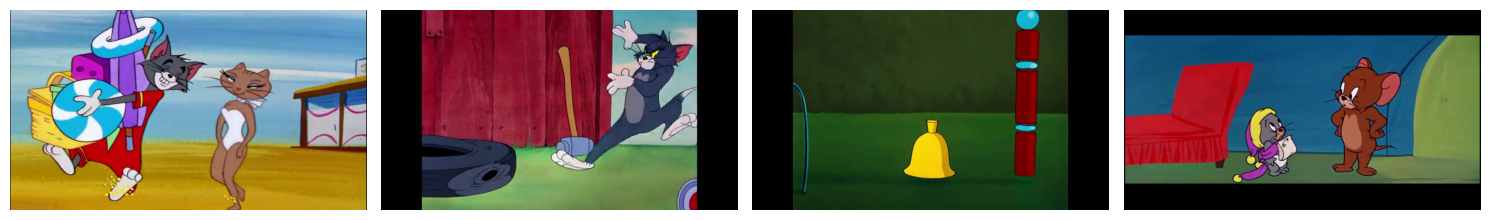

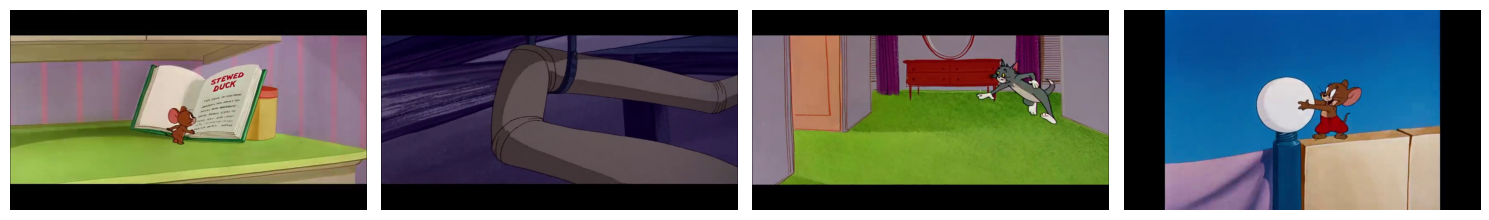

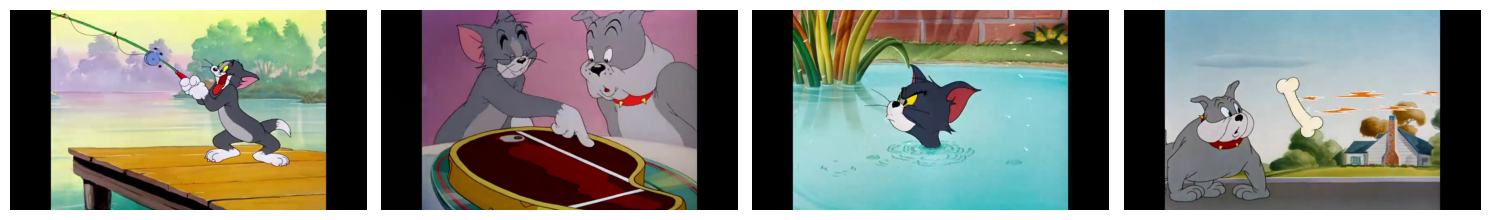

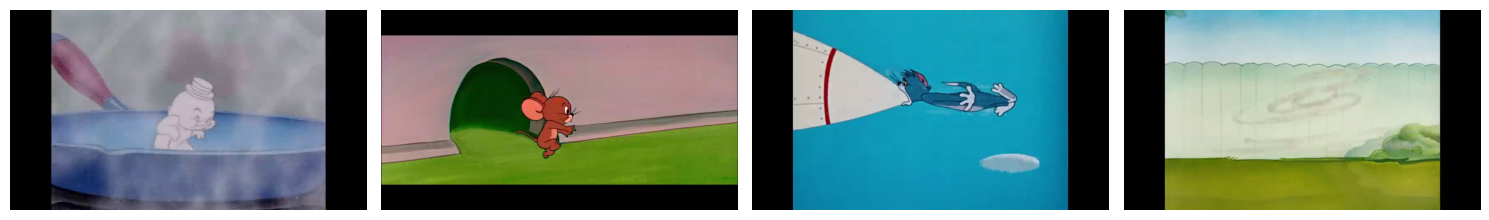

In [15]:
N_ROWS = 4
N_COLS = 4

for i in range(0, N_ROWS):
    fig, axs = plt.subplots(1, N_COLS, figsize=(15, 15))

    for j in range(N_COLS):
            id_j = np.random.randint(0, len(images_paths))
            img_path_i = images_paths[id_j]
            img_i = cv2.imread(img_path_i, 1)
            img_i = cv2.cvtColor(img_i, cv2.COLOR_BGR2RGB)

            axs[j].imshow(img_i, cmap='gray')
            axs[j].axis('off')

    fig.tight_layout()
    plt.show()

# Images Preprocessing

Blur Filters

In [16]:
# make image smooth
def apply_filter_gaussian(image, kernel_size=(5, 5), sigma=0):
    return cv2.GaussianBlur(image, kernel_size, sigma).astype(image.dtype)

# remove salt and pepper noise
def apply_filter_median(image, kernel_size=5):
    return cv2.medianBlur(image, kernel_size).astype(image.dtype)

# preserve edges while reducing noise
def apply_filter_bilateral(image, d=9, sigma_color=75, sigma_space=75):
    return cv2.bilateralFilter(image, d, sigma_color, sigma_space).astype(image.dtype)

In [17]:
def apply_gradient_magnitude(image):
    grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    mag = np.sqrt(grad_x ** 2 + grad_y ** 2)

    mag_norm = cv2.normalize(mag, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX) * 255

    return mag_norm.astype(image.dtype)

def apply_gradient_direction(image):
    grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    direction = np.arctan2(grad_y, grad_x)

    direction_norm = (direction + np.pi) / (2 * np.pi) * 255

    return direction_norm.astype(image.dtype)

Edge Detection

In [18]:
def apply_laplacian(image, ksize=3):
    return cv2.Laplacian(image, cv2.CV_32F, ksize=ksize).astype(image.dtype)

def apply_sobel(image, dx=1, dy=0, ksize=3):
    return cv2.Sobel(image, cv2.CV_32F, dx, dy, ksize=ksize).astype(image.dtype)

def apply_canny(image, threshold1=80, threshold2=150):
    return cv2.Canny(image, threshold1, threshold2).astype(image.dtype)

Kmeans

In [19]:
def apply_kmeans(image, n_colors = 24):
    n_channels = image.shape[2] if len(image.shape) == 3 else 1

    Z = image.reshape((-1, n_channels)).astype(np.float32)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _, label, center = cv2.kmeans(Z, n_colors, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    center = np.uint8(center)
    res = center[label.flatten()]

    clustered = res.reshape(image.shape)
    return clustered

In [20]:
def preprocess_image_from_path(image_path):
    image = cv2.imread(image_path, 1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image = cv2.resize(image, (IMG_H, IMG_W))

    image = apply_kmeans(image)
    grey_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    edge = apply_canny(grey_image)

    edge = np.expand_dims(edge, axis=-1)

    image = (image / 255.0).astype(np.float32)
    edge = (edge / 255.0).astype(np.float32)

    return [image, edge]

(224, 224, 3) (224, 224, 1) 0.7254902 0.0 1.0 0.0


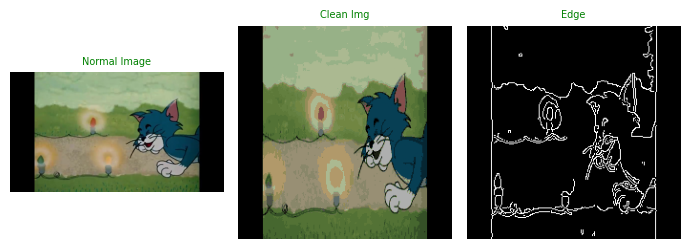

(224, 224, 3) (224, 224, 1) 0.80784315 0.0 1.0 0.0


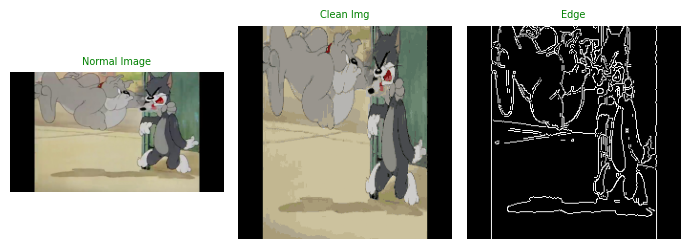

(224, 224, 3) (224, 224, 1) 0.8862745 0.050980393 1.0 0.0


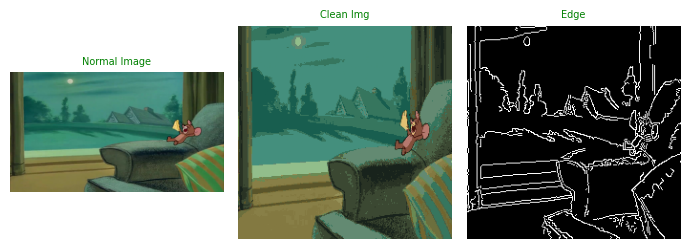

(224, 224, 3) (224, 224, 1) 0.78039217 0.0 1.0 0.0


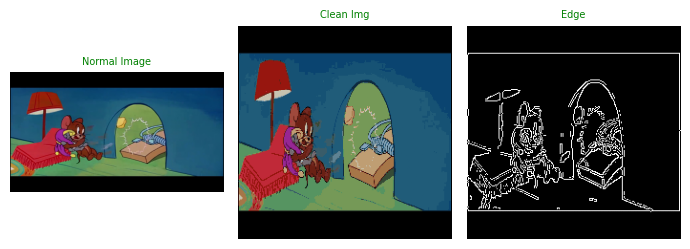

(224, 224, 3) (224, 224, 1) 0.9254902 0.0 1.0 0.0


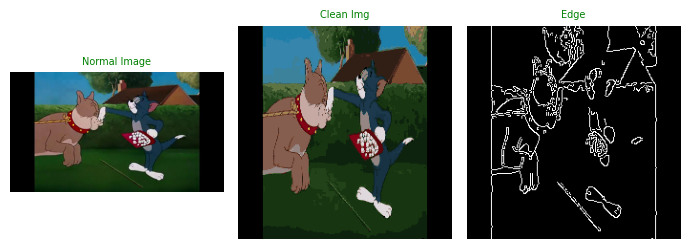

In [21]:
N_ROWS = 5
IMG_SHAPE = None

for i in range(0, N_ROWS):
    fig, axs = plt.subplots(1, 3, figsize=(7, 7))
    id_j = np.random.randint(0, len(images_paths))
    img_path_i = images_paths[id_j]

    img_i = cv2.imread(img_path_i, 1)
    img_i = cv2.cvtColor(img_i, cv2.COLOR_BGR2RGB)
    img_i_processed, edge_img = preprocess_image_from_path(img_path_i)

    print(img_i_processed.shape, edge_img.shape, np.max(img_i_processed), np.min(img_i_processed), np.max(edge_img), np.min(edge_img))

    axs[0].imshow(img_i.squeeze())
    axs[0].set_title(f"Normal Image", fontsize=7, color='green')
    axs[0].axis('off')

    axs[1].imshow(img_i_processed)
    axs[1].set_title(f"Clean Img", fontsize=7, color='green')
    axs[1].axis('off')

    axs[2].imshow(edge_img, cmap='gray')
    axs[2].set_title(f"Edge", fontsize=7, color='green')
    axs[2].axis('off')

    IMG_SHAPE = img_i_processed.shape

    fig.tight_layout()
    plt.show()

# Data Split

In [22]:
threshold = VAL_SPLIT * len(images_paths)

np.random.shuffle(images_paths)
images_paths_train = images_paths[:-int(threshold)]
images_paths_val = images_paths[-int(threshold):]

In [23]:
print(f"Train images: {len(images_paths_train)}")
print(f"Val images: {len(images_paths_val)}")

Train images: 4383
Val images: 1095


# Data Augmentation

In [24]:
def custom_augmentation_numpy(image, edge_img):
    # -----------------------------
    # 1. Random Horizontal Flip
    if np.random.rand() > 0.5:
        image = np.fliplr(image)
        edge_img = np.fliplr(edge_img)

    # -----------------------------
    # 2. Random Vertical Flip
    # if np.random.rand() > 0.5:
    #     image = np.flipud(image)
    #     edge_img = np.flipud(edge_img)

    # -----------------------------
    # 3. Random Rotation (-15 to 15 degrees)
    if np.random.rand() > 0.5:
        angle = np.random.uniform(-15, 15)
        h, w = image.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        image = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_REFLECT_101)
        edge_img = cv2.warpAffine(edge_img, M, (w, h), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_REFLECT_101)

    # -----------------------------
    # 4. Random Crop and Resize Back
    if np.random.rand() > 0.5:
        h, w = image.shape[:2]
        crop_scale = np.random.uniform(0.9, 1.0)
        new_h, new_w = int(h * crop_scale), int(w * crop_scale)
        top = np.random.randint(0, h - new_h + 1)
        left = np.random.randint(0, w - new_w + 1)
        image = image[top:top + new_h, left:left + new_w]
        edge_img = edge_img[top:top + new_h, left:left + new_w]
        image = cv2.resize(image, (w, h))
        edge_img = cv2.resize(edge_img, (w, h), interpolation=cv2.INTER_NEAREST)

    # -----------------------------
    # 5. Random Brightness (image only)
    if np.random.rand() > 0.5:
        brightness_shift = np.random.uniform(-0.05, 0.05)
        image = image + brightness_shift
        image = np.clip(image, 0, 1)

    # -----------------------------
    # 6. Random Contrast (image only)
    if np.random.rand() > 0.5:
        factor = np.random.uniform(0.8, 1.2)
        mean = image.mean(axis=(0, 1), keepdims=True)
        image = (image - mean) * factor + mean
        image = np.clip(image, 0, 1)

    # -----------------------------
    # 7. Random Gaussian Noise (image only)
    if np.random.rand() > 0.5:
        noise = np.random.normal(0, 0.025, image.shape)
        image = image + noise
        image = np.clip(image, 0, 1)

    if len(edge_img.shape) == 2:
      edge_img = np.expand_dims(edge_img,axis= -1)

    return image, edge_img


In [25]:
class MyDataGenerator(Sequence):
    # Shared cache across all objects of this class
    _shared_image_cache = dict()

    def __init__(self, images_paths, batch_size=32, augment=True, shuffle=True, n_workers=4):
        self.images_paths = np.array(images_paths)
        self.batch_size = batch_size
        self.augment = augment
        self.shuffle = shuffle
        self.n_workers = n_workers
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.images_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_x = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_images_paths = self.images_paths[batch_x]

        batch_images_edge_pairs = self._load_images_parallel(batch_images_paths)

        if self.augment:
            batch_images_edge_pairs = [custom_augmentation_numpy(*img) for img in batch_images_edge_pairs]

        return np.array([x[1] for x in batch_images_edge_pairs]), np.array([x[0] for x in batch_images_edge_pairs])

    def on_epoch_end(self):
        self.indices = np.arange(len(self.images_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def _load_images_parallel(self, paths):
        with ThreadPoolExecutor(max_workers=self.n_workers) as executor:
            image_edge_pairs = list(executor.map(self._load_and_preprocess_single, paths))
        return image_edge_pairs

    def _load_and_preprocess_single(self, path):
        if path in MyDataGenerator._shared_image_cache:
            return MyDataGenerator._shared_image_cache[path]
        else:
            image_edge_pair = preprocess_image_from_path(path)
            MyDataGenerator._shared_image_cache[path] = image_edge_pair
            return image_edge_pair

    @classmethod
    def clear_cache(cls):
        cls._shared_image_cache.clear()

In [26]:
train_generator = MyDataGenerator(images_paths_train, batch_size=6, augment=True, shuffle=True)
train_pure_generator = MyDataGenerator(images_paths_train, batch_size=6, augment=False, shuffle=False)
val_generator = MyDataGenerator(images_paths_val, batch_size=BATCH_SIZE, augment=False, shuffle=False)

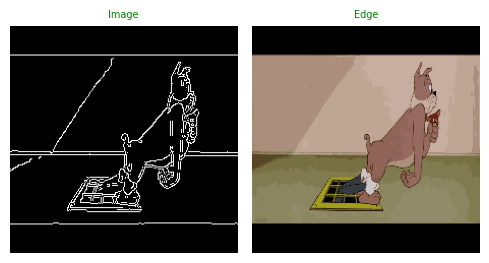

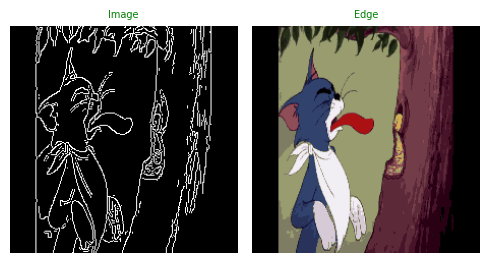

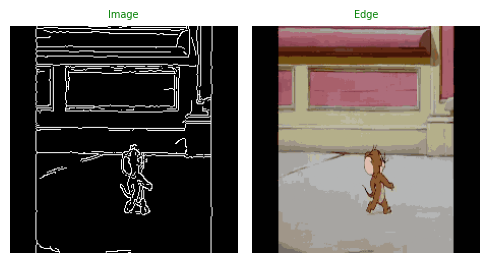

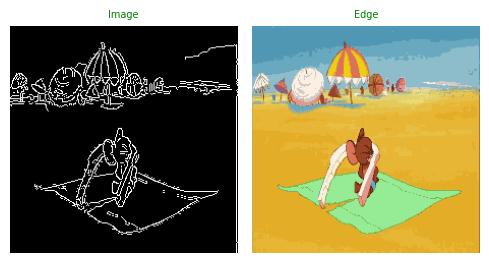

In [27]:
random_batch_x,random_batch_y  = val_generator[0]

for i in range(4):
    fig, axs = plt.subplots(1, 2, figsize=(5,5))
    axs[0].imshow(random_batch_x[i], cmap='gray')
    axs[0].set_title(f"Image", fontsize=7, color='green')
    axs[0].axis('off')
    axs[1].imshow(random_batch_y[i], cmap='gray')
    axs[1].set_title(f"Edge", fontsize=7, color='green')
    axs[1].axis('off')

    fig.tight_layout()
    plt.show()

# Model Encapsulation

In [40]:
CACHE_MODELS_DIR_NAME = os.path.join(BASE_DIR)
os.makedirs(CACHE_MODELS_DIR_NAME, exist_ok=True)

In [41]:
class CustomModel:
    def __init__(self, name, gen_model, discrim_model):
        self.name = re.sub('[^A-Za-z0-9]', '_', str(name)).lower()
        self.gen_model = gen_model
        self.discrim_model = discrim_model
        self.trained = False

        # Optimizers
        self.gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
        self.disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

        # Losses
        self.bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

        # Track losses
        self.loss_history = {
            "discriminator": [],
            "generator": []
        }

        self.load()

    def l1_loss(self, y_true, y_pred):
        return tf.reduce_mean(tf.abs(y_true - y_pred))

    def generator_loss(self, fake_output, y_true, y_pred, l1_weight=100):
        gan_loss = self.bce(tf.ones_like(fake_output), fake_output)
        l1 = self.l1_loss(y_true, y_pred)
        return gan_loss + l1_weight * l1

    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.bce(tf.ones_like(real_output), real_output)
        fake_loss = self.bce(tf.zeros_like(fake_output), fake_output)
        return (real_loss + fake_loss) * 0.5

    @tf.function
    def train_step(self, x, y, l1_weight=100):
        x = tf.cast(x, tf.float32)
        y = tf.cast(y, tf.float32)
        
        with tf.GradientTape(persistent=True) as tape:
            # Generator output
            fake_y = self.gen_model(x, training=True)

            # Discriminator outputs
            real_output = self.discrim_model(y, training=True)
            fake_output = self.discrim_model(fake_y, training=True)

            # Losses
            disc_loss = self.discriminator_loss(real_output, fake_output)
            gen_loss = self.generator_loss(fake_output, y, fake_y, l1_weight)

        # Gradients
        disc_grads = tape.gradient(disc_loss, self.discrim_model.trainable_variables)
        gen_grads = tape.gradient(gen_loss, self.gen_model.trainable_variables)

        # Optimizer steps
        self.disc_optimizer.apply_gradients(zip(disc_grads, self.discrim_model.trainable_variables))
        self.gen_optimizer.apply_gradients(zip(gen_grads, self.gen_model.trainable_variables))

        return disc_loss, gen_loss
        
    def fit(self, data_gen, epochs, l1_weight=100, val_data=None):
        for epoch in range(epochs):
            print(f'\nEpoch {epoch + 1}/{epochs}')
            total_d_loss = 0
            total_g_loss = 0
            batches = len(data_gen)
    
            for batch_i in range(batches):
                x_train, y_train = data_gen[batch_i]
    
                d_loss, g_loss = self.train_step(x_train, y_train, l1_weight)
                total_d_loss += d_loss.numpy()
                total_g_loss += g_loss.numpy()
    
                if batch_i % 10 == 0:
                    print(f'Batch {batch_i + 1}/{batches} | D Loss: {d_loss.numpy():.4f} | G Loss: {g_loss.numpy():.4f}')
    
            avg_d_loss = total_d_loss / batches
            avg_g_loss = total_g_loss / batches
    
            self.loss_history["discriminator"].append(avg_d_loss)
            self.loss_history["generator"].append(avg_g_loss)
    
            self.save()
    
            # -------------------------
            # Plot every 10 epochs
            if (epoch + 1) % 10 == 0 and val_data is not None:
                x_val, y_val = val_data[0]
                self.plot_sample_results(x_val[:3], y_val[:3], epoch=epoch+1)
            # -------------------------
    
        self.trained = True


    def load(self):
        g_file_path = f'{CACHE_MODELS_DIR_NAME}/{self.name}_generator.weights.h5'
        d_file_path = f'{CACHE_MODELS_DIR_NAME}/{self.name}_discrim.weights.h5'
        loss_file_path = f'{CACHE_MODELS_DIR_NAME}/{self.name}_loss.json'

        try:
            self.gen_model.load_weights(g_file_path)
            self.discrim_model.load_weights(d_file_path)
            self.trained = True
            print(f'Loaded weights for {self.name}')
        except Exception as e:
            print(f'No saved weights found for {self.name}, starting fresh.')

        if os.path.exists(loss_file_path):
            with open(loss_file_path, 'r') as f:
                self.loss_history = json.load(f)
            print(f'Loaded loss history for {self.name}')
        else:
            print('No previous loss history found, starting fresh.')

    def save(self):
        # Save weights
        self.gen_model.save_weights(f'{CACHE_MODELS_DIR_NAME}/{self.name}_generator.weights.h5')
        self.discrim_model.save_weights(f'{CACHE_MODELS_DIR_NAME}/{self.name}_discrim.weights.h5')

        # Save loss history
        loss_file_path = f'{CACHE_MODELS_DIR_NAME}/{self.name}_loss.json'
        with open(loss_file_path, 'w') as f:
            json.dump(self.loss_history, f)

        print(f'Saved model and losses for {self.name}')

    def plot_sample_results(self, x_samples, y_samples, epoch):
        preds = self.gen_model.predict(x_samples)
    
        fig, axes = plt.subplots(3, 3, figsize=(9, 9))
        fig.suptitle(f'{self.name} - Epoch {epoch} Sample Predictions', fontsize=16)
    
        for i in range(3):
            edge_img = x_samples[i].squeeze()
            gt_img = y_samples[i]
            pred_img = preds[i]
    
            if edge_img.ndim == 2:
                edge_img = np.stack([edge_img]*3, axis=-1)
    
            axes[i, 0].imshow(edge_img)
            axes[i, 0].set_title('Edge Input')
            axes[i, 1].imshow(gt_img)
            axes[i, 1].set_title('Ground Truth')
            axes[i, 2].imshow((pred_img + 1) / 2)  # assuming tanh [-1, 1]
            axes[i, 2].set_title('Prediction')
    
            for j in range(3):
                axes[i, j].axis('off')
    
        plt.tight_layout()
    
        save_dir = os.path.join(CACHE_MODELS_DIR_NAME, f"{self.name}_plots")
        os.makedirs(save_dir, exist_ok=True)
    
        plt.savefig(os.path.join(save_dir, f"epoch_{epoch}.png"))
        plt.close(fig)


# Models Arch

In [42]:
models_list = list()

In [43]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import tensorflow as tf


def SE_Block(input_tensor, reduction=16):
    filters = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Dense(filters // reduction, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    se = Reshape((1, 1, filters))(se)
    return Multiply()([input_tensor, se])


def ResidualBlock(x, filters):
    shortcut = x
    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([shortcut, x])
    x = LeakyReLU(0.2)(x)
    return x


def build_harder_gan_model():
    global models_list
    NAME = 'gan_unet_hardcore_no_sn'

    inputs = Input((IMG_H, IMG_W, 1))

    # Encoder
    e1 = Conv2D(64, 4, strides=2, padding='same')(inputs)
    e1 = LeakyReLU(0.2)(e1)

    e2 = Conv2D(128, 4, strides=2, padding='same')(e1)
    e2 = BatchNormalization()(e2)
    e2 = LeakyReLU(0.2)(e2)

    e3 = Conv2D(256, 4, strides=2, padding='same')(e2)
    e3 = BatchNormalization()(e3)
    e3 = LeakyReLU(0.2)(e3)

    e4 = Conv2D(512, 4, strides=2, padding='same')(e3)
    e4 = BatchNormalization()(e4)
    e4 = LeakyReLU(0.2)(e4)

    # Bottleneck + Residuals + SE block
    b = Conv2D(1024, 4, strides=2, padding='same')(e4)
    b = BatchNormalization()(b)
    b = Activation('relu')(b)
    for _ in range(3):
        b = ResidualBlock(b, 1024)
    b = SE_Block(b)

    # Decoder
    d1 = Conv2DTranspose(512, 4, strides=2, padding='same')(b)
    d1 = BatchNormalization()(d1)
    d1 = Dropout(0.5)(d1)
    d1 = Activation('relu')(d1)
    d1 = Concatenate()([d1, e4])

    d2 = Conv2DTranspose(256, 4, strides=2, padding='same')(d1)
    d2 = BatchNormalization()(d2)
    d2 = Dropout(0.5)(d2)
    d2 = Activation('relu')(d2)
    d2 = Concatenate()([d2, e3])

    d3 = Conv2DTranspose(128, 4, strides=2, padding='same')(d2)
    d3 = BatchNormalization()(d3)
    d3 = Activation('relu')(d3)
    d3 = Concatenate()([d3, e2])

    d4 = Conv2DTranspose(64, 4, strides=2, padding='same')(d3)
    d4 = BatchNormalization()(d4)
    d4 = Activation('relu')(d4)
    d4 = Concatenate()([d4, e1])

    d5 = Conv2DTranspose(64, 4, strides=2, padding='same')(d4)
    d5 = BatchNormalization()(d5)
    d5 = Activation('relu')(d5)

    outputs = Conv2D(3, 1, activation='tanh')(d5)

    gen_model = Model(inputs, outputs)
    gen_model.summary()

    ### --- Discriminator (No Spectral Norm) ---
    disc_in = Input((IMG_H, IMG_W, 3))
    d = Conv2D(64, 4, strides=2, padding='same')(disc_in)
    d = BatchNormalization()(d)
    d = LeakyReLU(0.2)(d)

    d = Conv2D(128, 4, strides=2, padding='same')(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(0.2)(d)

    d = Conv2D(256, 4, strides=2, padding='same')(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(0.2)(d)

    d = Conv2D(512, 4, strides=1, padding='same')(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(0.2)(d)

    outputs = Conv2D(1, 4, strides=1, padding='same')(d)

    descrim_model = Model(disc_in, outputs)
    descrim_model.summary()

    # Entire model
    entire_input = Input(shape=(IMG_H, IMG_W, 1))
    gen_output = gen_model(entire_input)
    discrim_output = descrim_model(gen_output)

    entire_model = Model(entire_input, discrim_output)

    custom_model = CustomModel(NAME, gen_model, descrim_model)
    models_list = list(filter(lambda x: x.name != custom_model.name, models_list))
    models_list.append(custom_model)
    
build_harder_gan_model()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 112, 112,  │      1,088 │ input_layer_6[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_22      │ (None, 112, 112,  │          0 │ conv2d_28[0][0]   │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 56, 56,    │    131,200 │ leaky_re_lu_22[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_29[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_23      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 28, 28,    │    524,544 │ leaky_re_lu_23[0… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │      1,024 │ conv2d_30[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_24      │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 14, 14,    │  2,097,664 │ leaky_re_lu_24[0… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │      2,048 │ conv2d_31[0][0]   │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_25      │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 7, 7,      │  8,389,632 │ leaky_re_lu_25[0… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7,      │      4,096 │ conv2d_32[0][0]   │
│ (BatchNormalizatio… │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_12       │ (None, 7, 7,      │          0 │ batch_normalizat… │
│ (Activation)        │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 7, 7,      │  9,438,208 │ activation_12[0]… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7,      │      4,096 │ conv2d_33[0][0] 

 Total params: 81,967,811 (312.68 MB)

 Trainable params: 81,949,635 (312.61 MB)

 Non-trainable params: 18,176 (71.00 KB)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 112, 112, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_32 (LeakyReLU)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 56, 56, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_33 (LeakyReLU)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 28, 28, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_34 (LeakyReLU)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 28, 28, 512)    │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 28, 28, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_35 (LeakyReLU)      │ (None, 28, 28, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 28, 28, 1)      │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,768,577 (10.56 MB)

 Trainable params: 2,766,657 (10.55 MB)

 Non-trainable params: 1,920 (7.50 KB)

No saved weights found for gan_unet_hardcore_no_sn, starting fresh.
No previous loss history found, starting fresh.


In [44]:
for model in models_list:

        plot_model(
            model.gen_model,
            to_file=  os.path.join(CACHE_MODELS_DIR_NAME,f'{model.name}_gen_arch.png'),
            show_shapes=True,
            dpi =200,
            show_layer_names=True,
            expand_nested=True,
            show_layer_activations=True,
            show_trainable=True,
            show_dtype=True,
        )

        plot_model(
            model.discrim_model,
            to_file=  os.path.join(CACHE_MODELS_DIR_NAME,f'{model.name}_descrim_arch.png'),
            show_shapes=True,
            dpi =200,
            show_layer_names=True,
            expand_nested=True,
            show_layer_activations=True,
            show_trainable=True,
            show_dtype=True,
        )


# Model Training

In [ ]:
for i, model in enumerate(models_list):
    print(f"{i+1}. Train: {model.name}")
    model.fit(train_generator, epochs= 150, val_data = val_generator)
    print('\n')

1. Train: gan_unet_hardcore_no_sn

Epoch 1/150


E0000 00:00:1753049310.077047      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape infunctional_6_1/dropout_4_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Batch 1/731 | D Loss: 0.7983 | G Loss: 53.6207
Batch 11/731 | D Loss: 0.5914 | G Loss: 26.1820
Batch 21/731 | D Loss: 0.5095 | G Loss: 28.6012
Batch 31/731 | D Loss: 0.5027 | G Loss: 22.6331
Batch 41/731 | D Loss: 0.5046 | G Loss: 22.0810
Batch 51/731 | D Loss: 0.6977 | G Loss: 23.9711
Batch 61/731 | D Loss: 0.4234 | G Loss: 19.4053
Batch 71/731 | D Loss: 0.3645 | G Loss: 25.7907
Batch 81/731 | D Loss: 0.2498 | G Loss: 20.3675
Batch 91/731 | D Loss: 0.5077 | G Loss: 17.9903
Batch 101/731 | D Loss: 0.3439 | G Loss: 20.8454
Batch 111/731 | D Loss: 0.1265 | G Loss: 23.0871
Batch 121/731 | D Loss: 0.4947 | G Loss: 22.5937
Batch 131/731 | D Loss: 0.2044 | G Loss: 19.8530
Batch 141/731 | D Loss: 0.4798 | G Loss: 23.6770
Batch 151/731 | D Loss: 0.2523 | G Loss: 21.5824
Batch 161/731 | D Loss: 0.1640 | G Loss: 21.1581
Batch 171/731 | D Loss: 0.2487 | G Loss: 23.5144
Batch 181/731 | D Loss: 0.2101 | G Loss: 21.1186
Batch 191/731 | D Loss: 0.4583 | G Loss: 22.2834
Batch 201/731 | D Loss: 0.1005 

E0000 00:00:1753050753.272537      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape infunctional_6_1/dropout_4_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Batch 731/731 | D Loss: 0.5564 | G Loss: 23.2102
Saved model and losses for gan_unet_hardcore_no_sn

Epoch 2/150
Batch 1/731 | D Loss: 0.2395 | G Loss: 19.0673
Batch 11/731 | D Loss: 0.4895 | G Loss: 19.2403
Batch 21/731 | D Loss: 0.2716 | G Loss: 19.4241
Batch 31/731 | D Loss: 0.3612 | G Loss: 17.2677
Batch 41/731 | D Loss: 0.8644 | G Loss: 18.0788
Batch 51/731 | D Loss: 0.5817 | G Loss: 22.2055
Batch 61/731 | D Loss: 0.2441 | G Loss: 18.3205
Batch 71/731 | D Loss: 0.3446 | G Loss: 21.5645
Batch 81/731 | D Loss: 0.2696 | G Loss: 18.1783
Batch 91/731 | D Loss: 0.7623 | G Loss: 16.7600
Batch 101/731 | D Loss: 0.2581 | G Loss: 19.3420
Batch 111/731 | D Loss: 0.3810 | G Loss: 22.2742
Batch 121/731 | D Loss: 0.4931 | G Loss: 15.9289
Batch 131/731 | D Loss: 0.3509 | G Loss: 18.3403
Batch 141/731 | D Loss: 0.3108 | G Loss: 19.4215
Batch 151/731 | D Loss: 0.7206 | G Loss: 19.8332
Batch 161/731 | D Loss: 0.2135 | G Loss: 19.6752
Batch 171/731 | D Loss: 0.2473 | G Loss: 22.4273
Batch 181/731 | 

E0000 00:00:1753051072.075702      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape infunctional_6_1/dropout_4_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Batch 731/731 | D Loss: 0.3319 | G Loss: 21.9145
Saved model and losses for gan_unet_hardcore_no_sn

Epoch 3/150
Batch 1/731 | D Loss: 0.6468 | G Loss: 18.6721
Batch 11/731 | D Loss: 0.3644 | G Loss: 18.0665
Batch 21/731 | D Loss: 0.4062 | G Loss: 19.4063
Batch 31/731 | D Loss: 0.2596 | G Loss: 17.8800
Batch 41/731 | D Loss: 0.4946 | G Loss: 18.6051
Batch 51/731 | D Loss: 0.4211 | G Loss: 22.3566
Batch 61/731 | D Loss: 0.2819 | G Loss: 17.3096
Batch 71/731 | D Loss: 0.2876 | G Loss: 20.8500
Batch 81/731 | D Loss: 0.8557 | G Loss: 19.3813
Batch 91/731 | D Loss: 0.5808 | G Loss: 17.5726
Batch 101/731 | D Loss: 0.3290 | G Loss: 15.6885
Batch 111/731 | D Loss: 0.3772 | G Loss: 24.7103
Batch 121/731 | D Loss: 0.2958 | G Loss: 19.5300
Batch 131/731 | D Loss: 0.2893 | G Loss: 18.9219
Batch 141/731 | D Loss: 0.1726 | G Loss: 21.7993
Batch 151/731 | D Loss: 0.7207 | G Loss: 18.5258
Batch 161/731 | D Loss: 0.2453 | G Loss: 20.7795
Batch 171/731 | D Loss: 0.5349 | G Loss: 21.2197
Batch 181/731 | 

I0000 00:00:1753053554.043826     108 service.cc:148] XLA service 0x786c942897f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753053554.049466     108 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1753053554.049493     108 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
E0000 00:00:1753053559.168474     108 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753053559.403803     108 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


I0000 00:00:1753053560.297638     108 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 11/150
Batch 1/731 | D Loss: 0.2633 | G Loss: 21.3954
Batch 11/731 | D Loss: 0.4484 | G Loss: 15.9750
Batch 21/731 | D Loss: 0.2701 | G Loss: 18.0094
Batch 31/731 | D Loss: 0.5058 | G Loss: 16.1727
Batch 41/731 | D Loss: 0.6173 | G Loss: 17.7701
Batch 51/731 | D Loss: 0.4217 | G Loss: 21.3776
Batch 61/731 | D Loss: 0.2007 | G Loss: 15.6996
Batch 71/731 | D Loss: 0.1444 | G Loss: 18.6224
Batch 81/731 | D Loss: 0.6067 | G Loss: 21.2636
Batch 91/731 | D Loss: 0.1921 | G Loss: 17.4709
Batch 101/731 | D Loss: 0.1483 | G Loss: 15.6274
Batch 111/731 | D Loss: 0.1804 | G Loss: 18.5802
Batch 121/731 | D Loss: 0.2638 | G Loss: 18.5532
Batch 131/731 | D Loss: 0.2745 | G Loss: 17.0842
Batch 141/731 | D Loss: 0.2267 | G Loss: 15.8249
Batch 151/731 | D Loss: 0.5238 | G Loss: 17.9335
Batch 161/731 | D Loss: 0.1208 | G Loss: 16.6966
Batch 171/731 | D Loss: 0.5110 | G Loss: 20.7418
Batch 181/731 | D Loss: 0.1354 | G Loss: 15.0963
Batch 191/731 | D Loss: 0.1627 | G Loss: 16.7457
Batch 201/731 | D

# Model Eval

In [ ]:
TEST_DIR_PATH = os.path.join(BASE_DIR,'test')
os.makedirs(TEST_DIR_PATH, exist_ok=True)

random_batch_x,random_batch_y  = val_generator[0]
random_batch_y_hat = models_list[0].gen_model.predict(random_batch_x)

for i in range(len(random_batch_x)):
    fig, axs = plt.subplots(1, 3, figsize=(5,5))
    axs[0].imshow(random_batch_x[i], cmap='gray')
    axs[0].set_title(f"Edge", fontsize=7, color='green')
    axs[0].axis('off')

    axs[1].imshow(random_batch_y[i])
    axs[1].set_title(f"True", fontsize=7, color='green')
    axs[1].axis('off')

    axs[2].imshow(random_batch_y_hat[i])
    axs[2].set_title(f"Predict Image", fontsize=7, color='green')
    axs[2].axis('off')

    fig.tight_layout()
    plt.savefig(os.path.join(TEST_DIR_PATH, f'test sample {i}.png'), dpi=300, bbox_inches='tight')  # dpi for quality, bbox_inches to avoid cutoff

In [ ]:
TRAIN_DIR_PATH = os.path.join(BASE_DIR,'train')
os.makedirs(TRAIN_DIR_PATH, exist_ok=True)

random_batch_x,random_batch_y = train_pure_generator[0]
random_batch_y_hat = models_list[0].gen_model.predict(random_batch_x)

for i in range(len(random_batch_x)):
    fig, axs = plt.subplots(1, 3, figsize=(5,5))
    axs[0].imshow(random_batch_x[i], cmap='gray')
    axs[0].set_title(f"Edge", fontsize=7, color='green')
    axs[0].axis('off')

    axs[1].imshow(random_batch_y[i], cmap='gray')
    axs[1].set_title(f"True", fontsize=7, color='green')
    axs[1].axis('off')

    axs[2].imshow(random_batch_y_hat[i], cmap='gray')
    axs[2].set_title(f"Predict Image", fontsize=7, color='green')
    axs[2].axis('off')

    fig.tight_layout()
    plt.savefig(os.path.join(TRAIN_DIR_PATH, f'train sample {i}.png'), dpi=300, bbox_inches='tight')  # dpi for quality, bbox_inches to avoid cutoff

# Depolyment